In [9]:
!echo ${FIFTYONE_PYPI_TOKEN}

d4feea0c8338058c


In [181]:
!nvidia-smi

Fri Jun 28 15:23:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:0C:00.0 Off |                  N/A |
| 64%   67C    P2             269W / 350W |   4435MiB / 24576MiB |     78%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os

CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

/home/jovyan/BA/classification


In [245]:
%%capture    
import os
os.environ['FIFTYONE_DATABASE_NAME'] = 'fiftyone-teams'
import fiftyone as fo
import fiftyone.core.storage as fos

import numpy as np
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt ## check to use PIL (low)
from tqdm import tqdm
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [246]:
sellpy_ds = fo.load_dataset("sellpy-test")
len(sellpy_ds)

243357

In [247]:
labels_to_filter = ['Women > Clothing','Kids > Clothing','Men > Clothing']
ds_clothing = sellpy_ds.match({"lvl1.label": {"$in": labels_to_filter}})
print(ds_clothing)

Dataset:     sellpy-test
Media type:  image
Num samples: 204652
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    lvl0:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl1:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl2:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl3:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    size:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    color:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    fabric:         fiftyon

In [248]:
all_brands = ds_clothing.distinct("brand.label")
print(len(all_brands))

13207


In [249]:
all_brands = ds_clothing.count_values("brand.label")
len(all_brands) 

13207

In [250]:
#sellpy_ds.distinct("lvl1.label")

In [251]:
def prepare_plot_data_distribution(data, limit):
    all_brands = data.count_values("brand.label")
    all_brands_as_tuples = all_brands.items() #dict
    all_classes= pd.DataFrame(list(all_brands_as_tuples), columns=['Class', 'Instances'])
    data_length = len(all_classes['Class'])
    nm_samples = all_classes['Instances'].sum()
       
    print(f'[INFO]: Number of Classes: {data_length}')
    print(f'[INFO]: Number of Samples: {nm_samples}')
        # Find and print the class with the most instances
    max_instance_index = all_classes['Instances'].idxmax()
    max_instance_class = all_classes.loc[max_instance_index]
    print(f'[INFO]: Class with the most instances: Index {max_instance_index}, {max_instance_class["Class"]} with {max_instance_class["Instances"]} instances')
    
        # Filter 
    others_idx = all_classes['Instances'] < limit
    filtered_classes = all_classes[~others_idx]
    others = all_classes[others_idx].sort_values('Instances', ascending=True)

    # Step 1: Aggregate the instances in the 'others' DataFrame
    others_aggregated = pd.DataFrame([['Others', others['Instances'].max()]], columns=['Class', 'Instances'])

    # Step 2: Append this aggregated row to the 'filtered_classes' DataFrame
    combined_classes = pd.concat([filtered_classes, others_aggregated], ignore_index=True)
    combined_sorted_classes = combined_classes.sort_values('Instances', ascending=True)
    return combined_sorted_classes, others
    

In [252]:
def plot_data_distribution(classes_with_hugeNumbers, others, title):
    x = classes_with_hugeNumbers['Class']
    y = classes_with_hugeNumbers['Instances']
    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    plt.barh(x,y)
    #plt.title(f'Number of Instances for Each Brand Name or Category{title}')
    plt.ylabel('Brand Name')
    plt.xlabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.grid(False)  # Enable grid for better readability
    plt.tight_layout() 
    plt.savefig(f"Datasets/Sellpy_Data_Distribution_1_{title}.png")
    plt.show()
    
    
        # Plotting the "Others" category separately
    length = range(len(others['Class']))
    plt.figure(figsize=(6, 4))
    plt.bar(length, others['Instances'], color='salmon')
    #plt.title(f'Number of Instances per Class for "Others" Category{title}')
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(f'Datasets/Sellpy_Data_Distribution_2_{title}.png')
    plt.show()

[INFO]: Number of Classes: 13207
[INFO]: Number of Samples: 204652
[INFO]: Class with the most instances: Index 245, H&M with 16883 instances


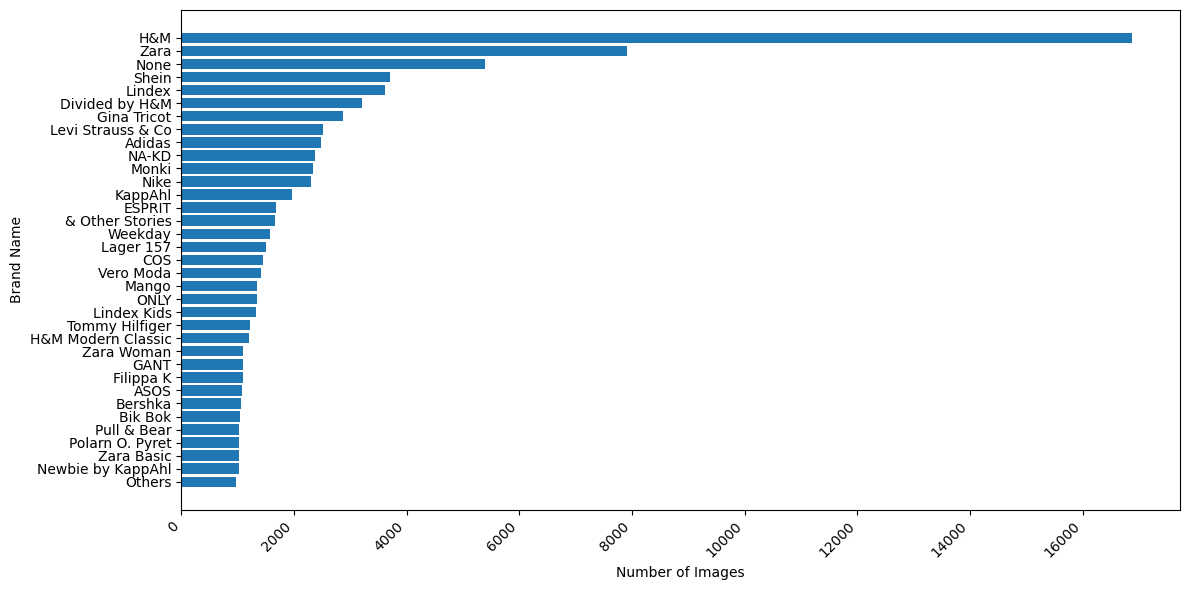

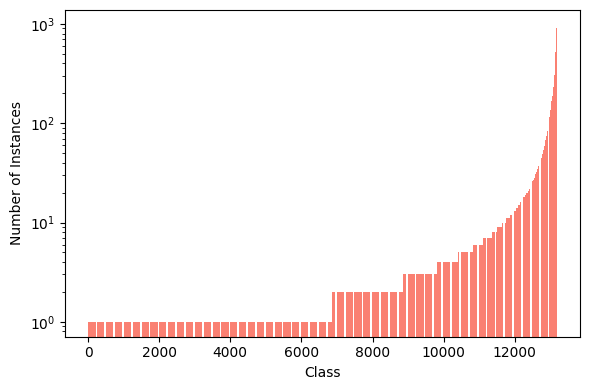

In [253]:
title = ''
limit = 1000
classes_with_hugeNumbers, others = prepare_plot_data_distribution(ds_clothing, limit)
plot_data_distribution(classes_with_hugeNumbers, others, title)

['arm',
 'belt',
 'button',
 'hanger',
 'hood',
 'logo',
 'mannequin',
 'neck',
 'pocket',
 'zipper']

In [10]:
#limit = 10000
# get all ids
ds_temp = ds_clothing.match(fo.ViewField("Grounding_Dino") !=  None)
print(ds_temp)
ids = ds_temp.values("id")
# check weather the sample contains a logo
contains_logo = ["logo" in values for values in ds_temp.values("Grounding_Dino.detections.label")]
# get ids of sample containing a logo 
ids_contains_logo = np.array(ids)[contains_logo]
# filter the data set to contain only samples with a logo found
ds_with_logos = sellpy_ds[ids_contains_logo]

Dataset:     sellpy-test
Media type:  image
Num samples: 204651
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    lvl0:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl1:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl2:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl3:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    size:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    color:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    fabric:         fiftyon

In [148]:
ds_temp.distinct("Grounding_Dino.detections.label")

['arm',
 'belt',
 'button',
 'hanger',
 'hood',
 'logo',
 'mannequin',
 'neck',
 'pocket',
 'zipper']

In [12]:
print(ds_with_logos)

Dataset:     sellpy-test
Media type:  image
Num samples: 37499
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    lvl0:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl1:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl2:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lvl3:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    size:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    color:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    fabric:         fiftyone

In [13]:
brand_values = ds_with_logos.count_values("brand.label")
brands=list(brand_values.keys())
len(brands)

5176

In [14]:
title = ' (Only With Logos)'
limit = 150

[INFO]: Number of Classes: 5176
[INFO]: Number of Samples: 37499
[INFO]: Class with the most instances: Index 2150, H&M with 2435 instances


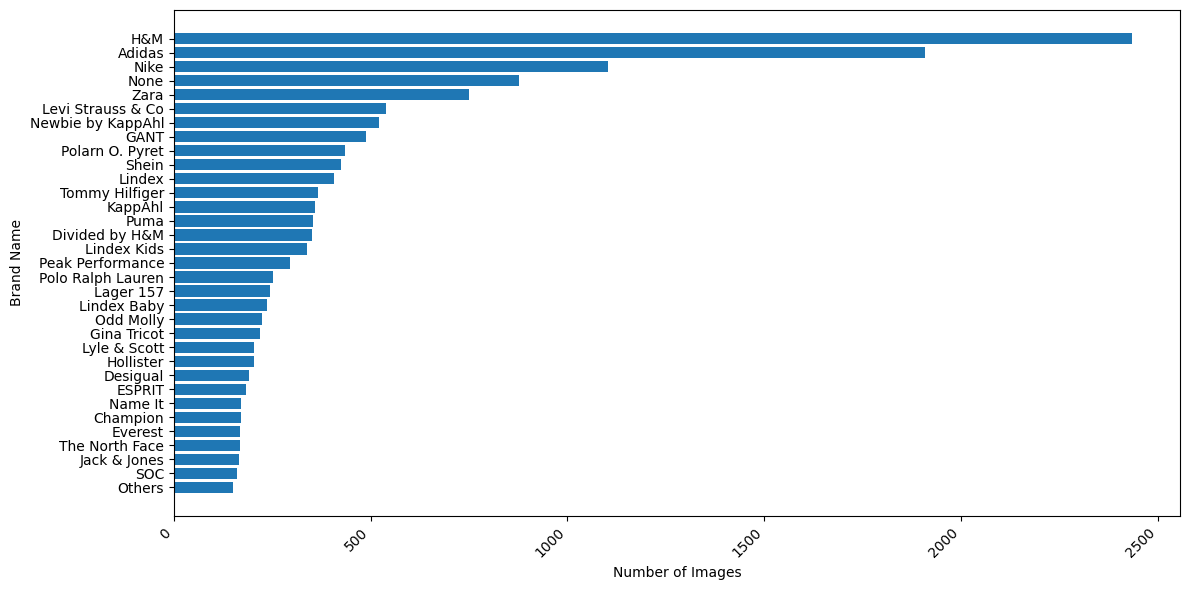

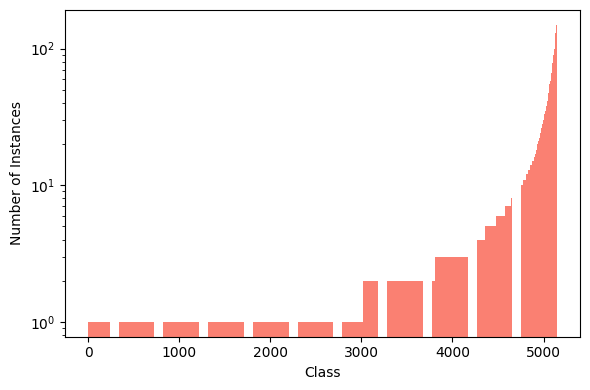

In [15]:
classes_with_hugeNumbers, others = prepare_plot_data_distribution(ds_with_logos, limit)
plot_data_distribution(classes_with_hugeNumbers, others, title)

# Image2K (Clothes)

In [254]:
import engine
import train
import data_setup
import model_builder
import config
from utilities.helper import save_model, get_num_correct, set_seed, create_target_dir, create_dir

In [261]:
from pathlib import Path
#DATA_DIR = Path('Datasets/Clothes/') 
DATA_DIR = Path('Datasets/ClothesModified/') 
#DATA_DIR = Path('Datasets/Data_Logo2K/')

In [262]:
transforms_train, transforms_valid = data_setup.get_transforms()

[INFO]: Transforms are Done ..


In [271]:
from collections import Counter

# Load the dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transforms_train)

# Count the instances of each class directly from the dataset targets
class_counts = Counter([dataset.classes[label] for _, label in dataset.samples])

# Delete None Class
#del class_counts['None']
# Convert the Counter
class_counts = dict(class_counts)
# Convert the counts to a pandas DataFrame for easier plotting
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Instances'])

In [272]:
def prepare_plot_data2_distribution(data, limit):
    data_length = len(data['Class'])
    nm_samples = data['Instances'].sum()
       
    print(f'[INFO]: Number of Classes: {data_length}')
    print(f'[INFO]: Number of Samples: {nm_samples}')
        # Find and print the class with the most instances
    max_instance_index = data['Instances'].idxmax()
    max_instance_class = data.loc[max_instance_index]
    print(f'[INFO]: Class with the most instances: Index {max_instance_index}, {max_instance_class["Class"]} with {max_instance_class["Instances"]} instances')
    
        # Filter 
    others_idx = data['Instances'] < limit
    filtered_classes = data[~others_idx]
    others = data[others_idx].sort_values('Instances', ascending=True)

    # Step 1: Aggregate the instances in the 'others' DataFrame
    others_aggregated = pd.DataFrame([['Others', others['Instances'].max()]], columns=['Class', 'Instances'])

    # Step 2: Append this aggregated row to the 'filtered_classes' DataFrame
    combined_classes = pd.concat([filtered_classes, others_aggregated], ignore_index=True)
    combined_sorted_classes = combined_classes.sort_values('Instances', ascending=True)
    #combined_sorted_classes = combined_classes
    return combined_sorted_classes, others
    

In [273]:
def plot_data2_distribution(classes_with_hugeNumbers, others, title):
    x = range(len(classes_with_hugeNumbers['Class']))
    y = classes_with_hugeNumbers['Instances']
    plt.figure(figsize=(12, 6))
    plt.bar(x,y)
    #plt.title(f'Number of Instances per Class{title}')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.grid(False)  # Enable grid for better readability
    plt.tight_layout() 
    plt.savefig(f"Datasets/Image2K_Data_Distribution_{title}.png")
    plt.show()

In [275]:
title = 'ClothesModifiedWithNone'
limit = 0

[INFO]: Number of Classes: 297
[INFO]: Number of Samples: 21214
[INFO]: Class with the most instances: Index 211, None with 150 instances


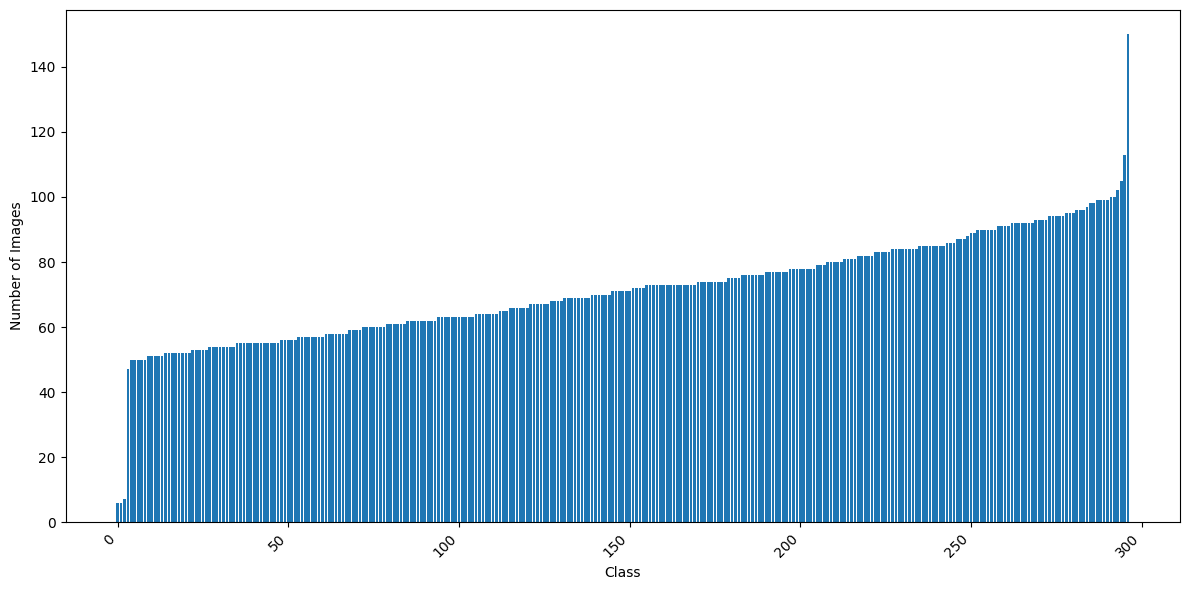

In [276]:
classes_with_hugeNumbers, others = prepare_plot_data2_distribution(class_counts_df, limit)
plot_data2_distribution(classes_with_hugeNumbers, others, title)

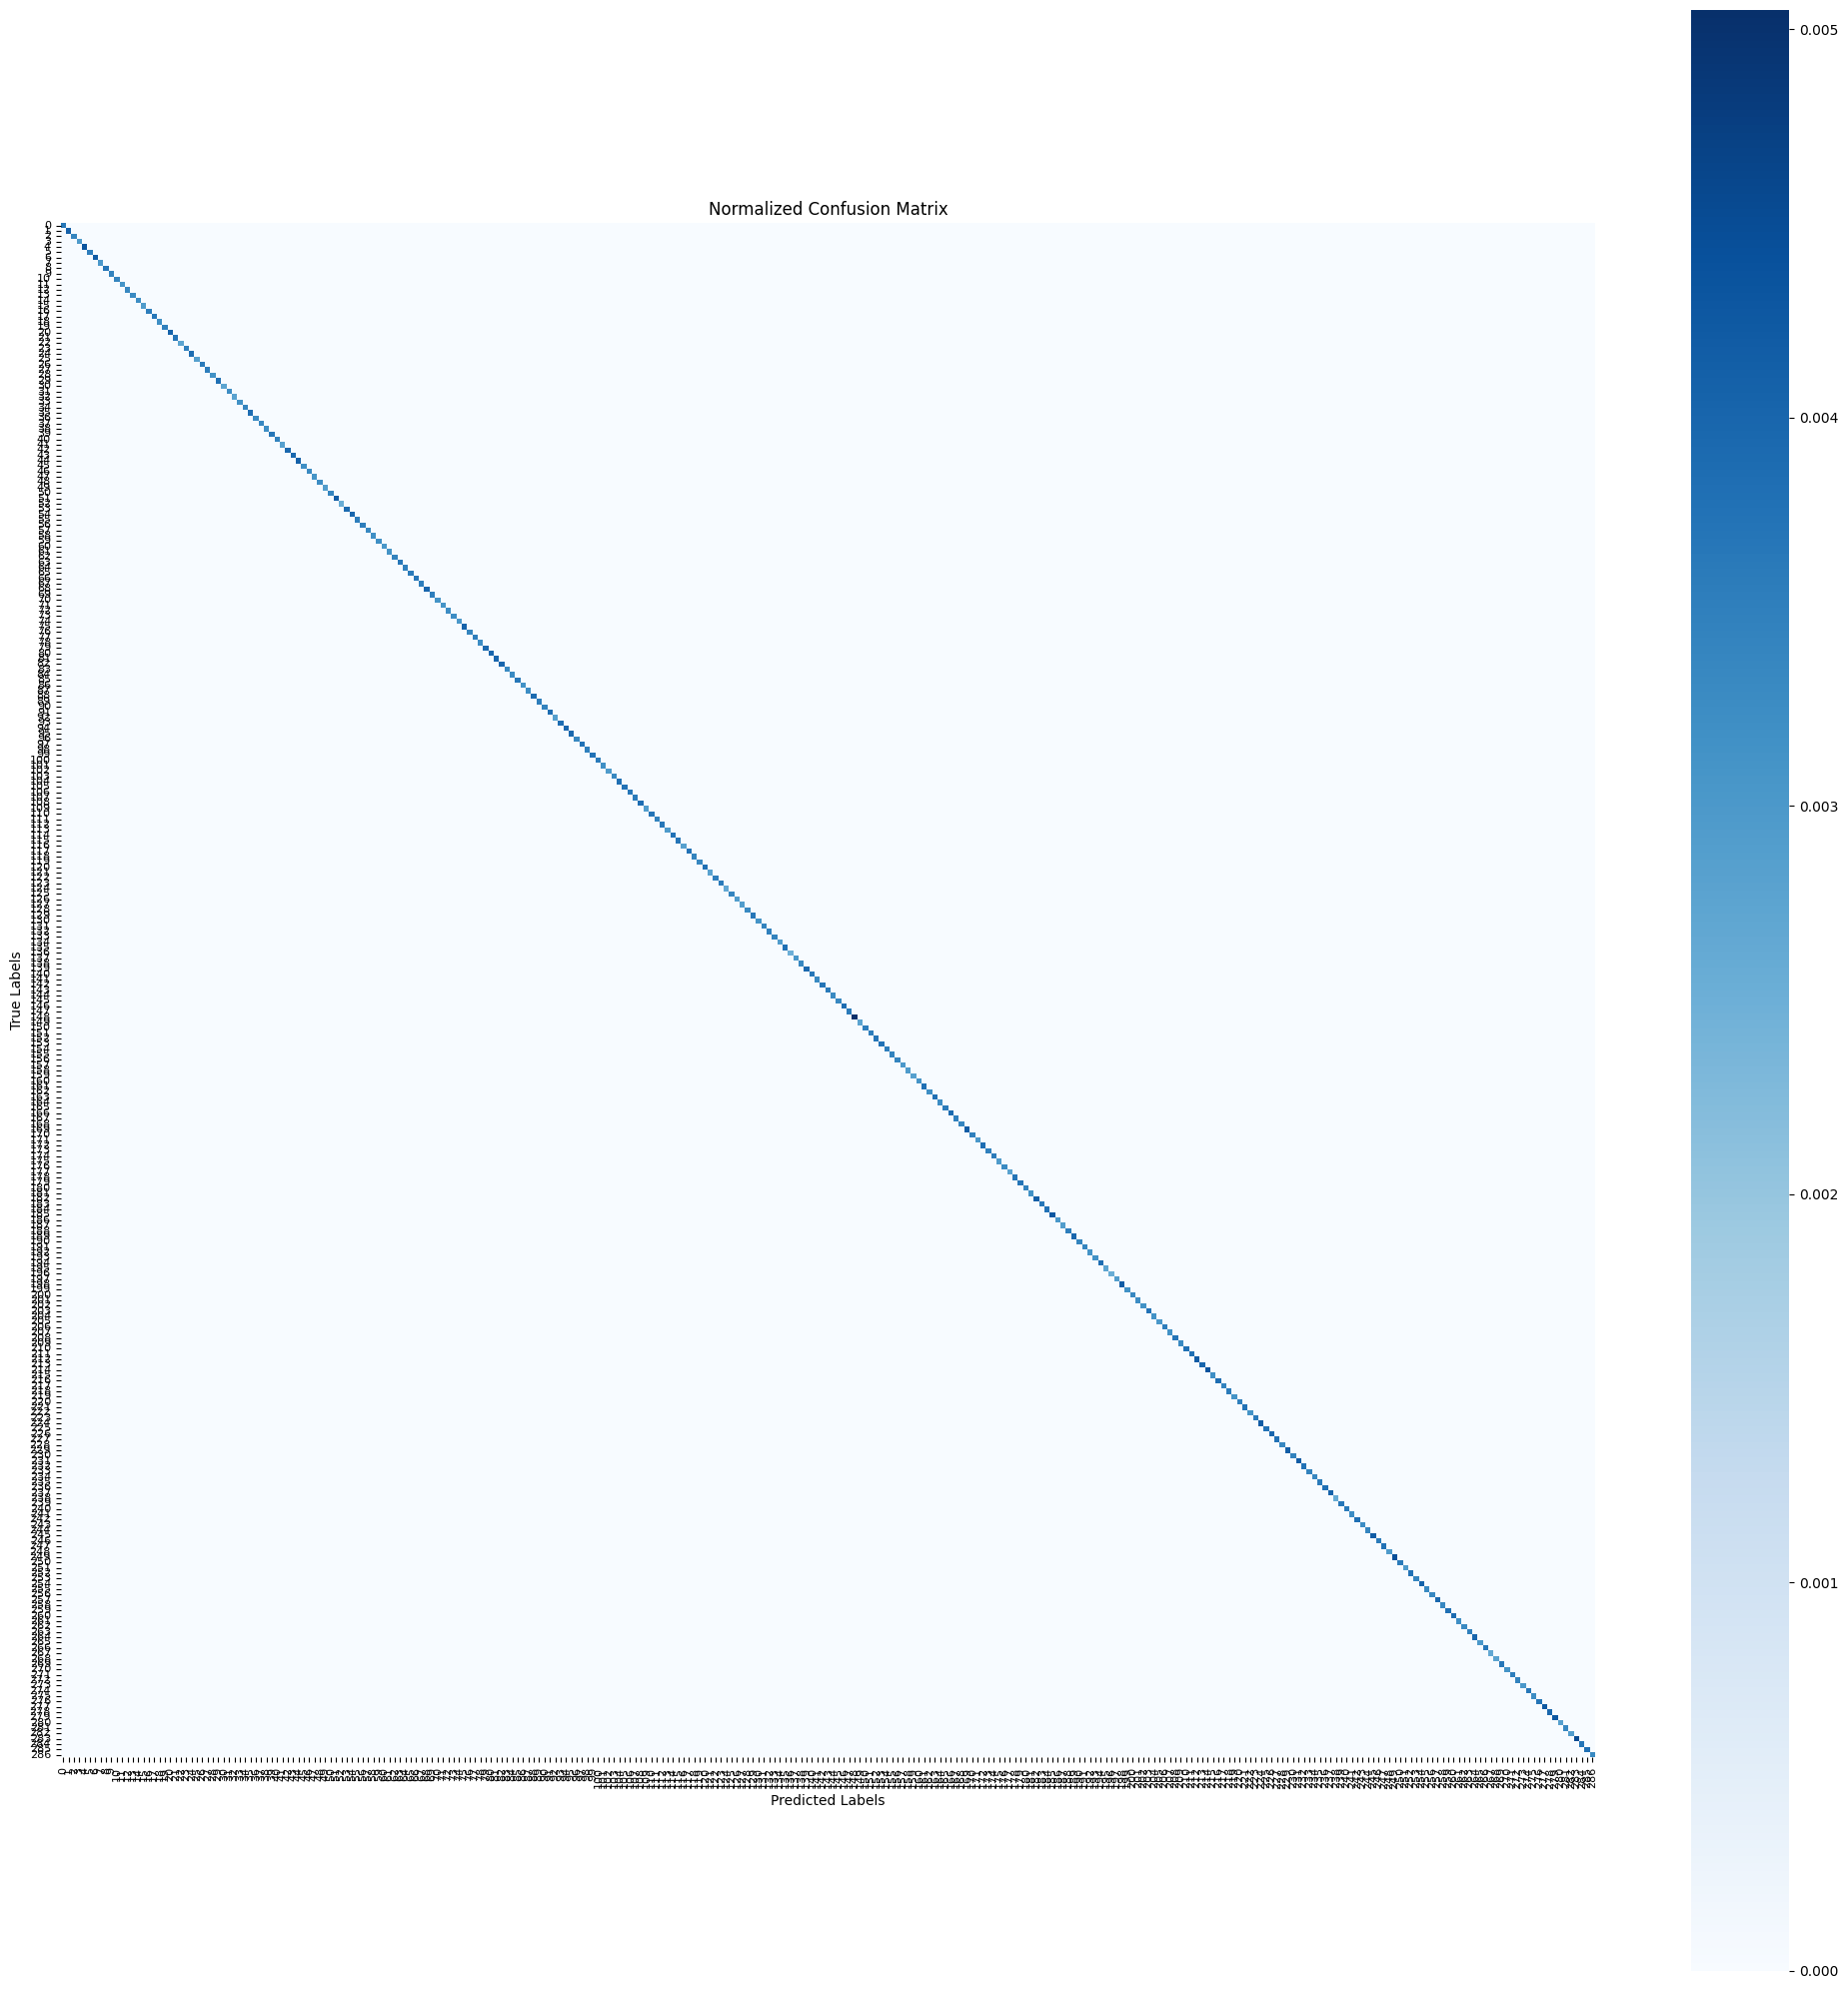

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.random.randint(0, 287, 20000) 
y_pred = y_true

cm = confusion_matrix(y_true, y_pred, normalize='all')


plt.figure(figsize=(20, 20))

sns.heatmap(cm, cmap="Blues", annot=False, fmt=".2f", square=True, 
            xticklabels=range(287), 
            yticklabels=range(287))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=0)
plt.tight_layout()
plt.title('Normalized Confusion Matrix')

plt.show()


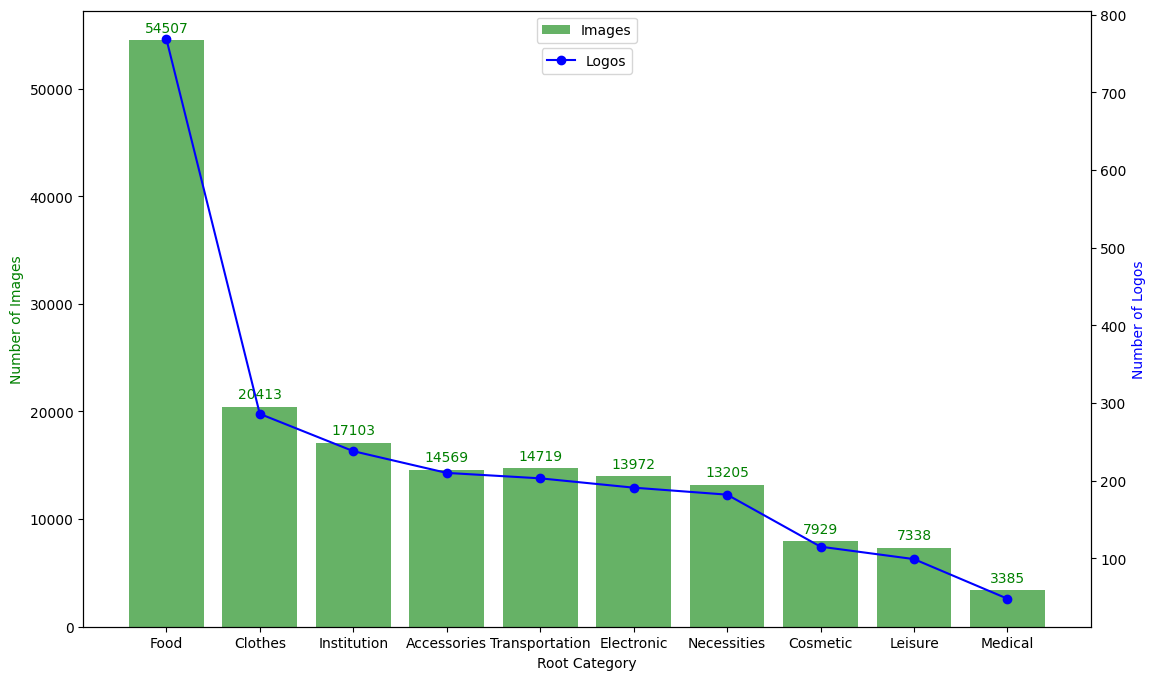

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Root Category': ['Food', 'Clothes', 'Institution', 'Accessories', 'Transportation', 'Electronic', 'Necessities', 'Cosmetic', 'Leisure', 'Medical'],
    'Logos': [769, 286, 238, 210, 203, 191, 182, 115, 99, 48],
    'Images': [54507, 20413, 17103, 14569, 14719, 13972, 13205, 7929, 7338, 3385]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.bar(df['Root Category'], df['Images'], color='g', alpha=0.6, label='Images')
ax2 = ax1.twinx()
ax2.plot(df['Root Category'], df['Logos'], color='b',  marker='o', label='Logos')


# Add numbers above the bars
for i, value in enumerate(df['Images']):
    ax1.text(i, value + 500, str(value), ha='center', va='bottom', color='g')

ax1.set_xlabel('Root Category')
ax1.set_ylabel('Number of Images', color='g')
ax2.set_ylabel('Number of Logos', color='b')

ax1.legend(loc='upper center')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
fig.savefig('logo2k.png')

plt.show()


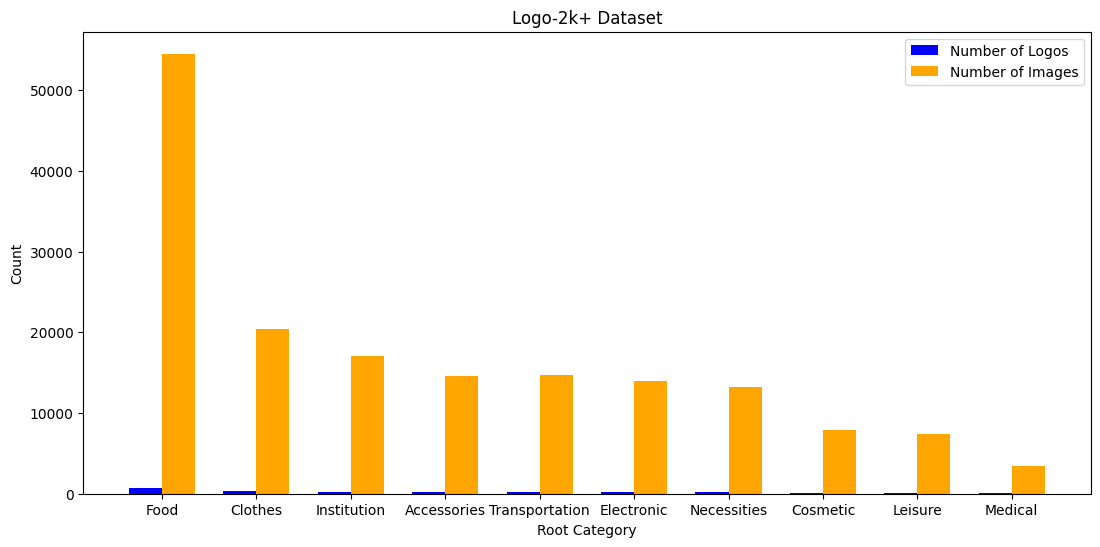

In [93]:
fig, ax = plt.subplots(figsize=(13, 6))

bar_width = 0.35
index = range(len(df))

bar1 = ax.bar([i - bar_width/2 for i in index], df['Logos'], bar_width, label='Number of Logos', color='blue')
bar2 = ax.bar([i + bar_width/2 for i in index], df['Images'], bar_width, label='Number of Images', color='orange')

ax.set_xlabel('Root Category')
ax.set_ylabel('Count')
ax.set_title('Logo-2k+ Dataset')
ax.set_xticks(index)
ax.set_xticklabels(df['Root Category'])

ax.legend()

plt.show()


In [280]:
import os
import shutil


image_dir = '/home/jovyan/BA/BA/evaluation/Best/ClassifiedAsNone'
new_image_dir = '/home/jovyan/BA/BA/evaluation/Best/AsNoneSorted'

if not os.path.exists(image_dir):
    raise ValueError(f"Directory {image_dir} does not exist")

files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Process each file
for file in files:
    # Find the part of the filename after 'true_'
    try:
        # Split the filename to get the label
        label = file.split('true_')[1].split('.')[0]
        
      
        target_dir = os.path.join(new_image_dir, label)
        
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        
        shutil.move(os.path.join(image_dir, file), os.path.join(target_dir, file))
    except IndexError:
        print(f"Filename {file} does not match the expected pattern. Skipping.")

print("Files have been grouped into directories based on their labels.")


Files have been grouped into directories based on their labels.


In [ ]:
import matplotlib.pyplot as plt

models = ['Experiment 1', 'Experiment 2', 'Experiment 3']
training_accuracy = [0.6277, 0.6403, 0.6402]
validation_accuracy = [0.7432, 0.7619, 0.7612]
training_f1_score =  [0.6257, 0.6412, 0.6411] 
validation_f1_score = [0.7423, 0.7620, 0.7620]

plt.figure(figsize=(10, 6))


plt.plot(models, training_accuracy, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(models, validation_accuracy, marker='s', linestyle='--', label='Validation Accuracy')
plt.plot(models, training_f1_score, marker='^', linestyle='-.', label='Training Weighted F1 Score')
plt.plot(models, validation_f1_score, marker='d', linestyle=':', label='Validation Weighted F1 Score')

plt.xlabel('Model')
plt.ylabel('Score')
#plt.title('Performance Comparison')
plt.legend()

plt.savefig('performance_comparison.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

metrics_ordered = [
    'Accuracy', 'Macro Avg Precision', 'Weighted Avg Precision',
    'Macro Avg Recall', 'Weighted Avg Recall', 'Macro Avg F1-Score', 'Weighted Avg F1-Score'
]
values_ordered = [74.946, 13.641, 92.124, 12.293, 74.946, 11.315, 79.751]

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.get_cmap('tab20')(range(len(metrics_ordered)))
bars = ax.bar(metrics_ordered, values_ordered, color=colors)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}%', ha='center', va='bottom')

ax.set_xlabel('Metric')
ax.set_ylabel('Value (%)')
plt.xticks(rotation=45, ha='right')
ax.set_ylim(0, 100)

path = '/home/jovyan/BA/BA/evaluation/Best/Performance.png'
plt.tight_layout()
plt.savefig(path)
plt.show()


In [ ]:
def read_classification_report(file_path):
    file_path = f'{file_path}/classificationReport.txt'
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

In [ ]:
import matplotlib.pyplot as plt

def parse_classification_report(lines):
    metrics = {
        'accuracy': 0,
        'macro_avg': {'precision': 0, 'recall': 0, 'f1_score': 0},
        'weighted_avg': {'precision': 0, 'recall': 0, 'f1_score': 0}
    }
    for line in lines:
        if 'accuracy' in line:
            metrics['accuracy'] = float(line.split()[1])
        elif 'macro avg' in line:
            metrics['macro_avg']['precision'] = float(line.split()[2])
            metrics['macro_avg']['recall'] = float(line.split()[3])
            metrics['macro_avg']['f1_score'] = float(line.split()[4])
        elif 'weighted avg' in line:
            metrics['weighted_avg']['precision'] = float(line.split()[2])
            metrics['weighted_avg']['recall'] = float(line.split()[3])
            metrics['weighted_avg']['f1_score'] = float(line.split()[4])
    return metrics

def plot_metrics(metrics, model_name, file_path):
    labels = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score', 
              'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score']
    values = [metrics['accuracy'], 
              metrics['macro_avg']['precision'], metrics['macro_avg']['recall'], metrics['macro_avg']['f1_score'],
              metrics['weighted_avg']['precision'], metrics['weighted_avg']['recall'], metrics['weighted_avg']['f1_score']]
    
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])
    plt.ylim(0, 1)
    plt.title(f'Performance Metrics {model_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    
    for i in range(len(values)):
        plt.text(i, values[i] + 0.01, f'{values[i]:.2f}', ha='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{file_path}/Performance_Metrics.png')
    plt.show()

file_path = '/home/jovyan/BA/evaluation/2024-06-05_15:29/'
lines = read_classification_report(file_path)
metrics = parse_classification_report(lines)
#plot_metrics(metrics, '', file_path)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the classes
classes = ['Adidas (8)', 'Nike (208)', 'None (211)', 'Calvin Klein (49)', 'Hummel (132)', 'Arena (22)', 'Boss (37)', 'Burberry (44)', 'Ellesse (90)', 'Vans (284)']
precision = [1.00, 0.86, 1.00, 0.99, 0.96, 0.33, 0.33, 1.00, 0.97, 0.90]
recall = [0.89, 0.81, 0.76, 0.60, 0.70, 0.80, 0.88, 0.50, 0.95, 0.86]
f1_score = [0.94, 0.83, 0.86, 0.75, 0.81, 0.47, 0.48, 0.67, 0.96, 0.88]

# Sorting indices by f1-score in descending order
sorted_indices = np.argsort(f1_score)[::-1]

# Sorting the data
sorted_classes = [classes[i] for i in sorted_indices]
sorted_precision = [precision[i] for i in sorted_indices]
sorted_recall = [recall[i] for i in sorted_indices]
sorted_f1_score = [f1_score[i] for i in sorted_indices]

x = np.arange(len(sorted_classes))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 9))
rects1 = ax.bar(x - width, sorted_precision, width, label='Precision')
rects2 = ax.bar(x, sorted_recall, width, label='Recall')
rects3 = ax.bar(x + width, sorted_f1_score, width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(sorted_classes, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Save the figure
path = '/home/jovyan/BA/BA/evaluation/Best/Performance.png'
plt.savefig(path)

plt.show()
